[VAE](https://en.wikipedia.org/wiki/Variational_autoencoder)

[Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

## GP 1D Data Generator

In [2]:
#import os,sys
#sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
import numpy as np  
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern


In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
class GP1D(Dataset):
    def __init__(self, dataPoints=100, samples=10000, ingrid=True, x_lim = 1,
                        seed=np.random.randint(20), kernel='rbf',ls = 0.1, nu=2.5):
        self.dataPoints = dataPoints
        self.samples = samples
        self.ingrid = ingrid
        self.x_lim = x_lim
        self.seed = seed
        self.Max_Points = 2 * dataPoints
        self.ls = ls
        self.nu = nu
        self.kernel = kernel
        np.random.seed(self.seed)
        self.evalPoints, self.data = self.__simulatedata__()
    
    def __len__(self):
        return self.samples
    
    def __getitem__(self, idx=0):
        return(self.evalPoints[:,idx], self.data[:,idx])


    def __simulatedata__(self):
        if self.kernel=='rbf':
            gp = GaussianProcessRegressor(kernel=RBF(length_scale=self.ls))
        elif self.kernel=='matern':
            gp = GaussianProcessRegressor(kernel=Matern(length_scale=self.ls, nu=self.nu))
        else:
            return None
        if (self.ingrid):
            X_ = np.linspace(-self.x_lim, self.x_lim, self.dataPoints)
            y_samples = gp.sample_y(X_[:, np.newaxis], self.samples)
            # print(X_.shape, y_samples.shape)
            return (X_.repeat(self.samples).reshape(X_.shape[0],self.samples) ,
                        y_samples)
        else:
            X_ = np.linspace(-self.x_lim, self.x_lim, self.Max_Points)
            X_ = np.random.choice(X_, (self.dataPoints,self.samples))
            X_.sort(axis=0)
            y_samples = np.zeros((self.dataPoints,self.samples))
            for idx in range(self.samples):
                x_ = X_[:,idx]
                y_samples[:,idx] = gp.sample_y(x_[:, np.newaxis]).reshape(self.dataPoints,)
            # print(X_.shape, y_samples.shape)
            return (X_, y_samples)

___

## VAE = Encoder + Decoder

In [5]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.distributions import Normal

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.mu = nn.Linear(hidden2_dim, z_dim)
        self.std = nn.Linear(hidden2_dim, z_dim)

    def forward(self, x):
        hidden1 = torch.tanh(self.linear1(x))
        hidden2 = torch.tanh_(self.linear2(hidden1))
        z_mu = self.mu(hidden2)
        z_std = self.std(hidden2)

        return z_mu, z_std

In [7]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden1_dim, hidden2_dim, input_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(z_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.out = nn.Linear(hidden2_dim, input_dim)

    def forward(self, z):
        hidden1 = torch.tanh(self.linear1(z))
        hidden2 = torch.tanh(self.linear2(hidden1))
        pred = self.out(hidden2)

        return pred

torch.randn_like(input, *, dtype=None, layout=None, device=None, requires_grad=False, memory_format=torch.preserve_format) 

Returns a tensor with the same size as input filled with random numbers from a normal **distribution with mean 0 and variance 1**

torch.randn_like(input) is equivalent to torch.randn(input.size(), dtype=input.dtype, layout=input.layout, device=input.device).

In [137]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim, hidden1_dim, hidden2_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden1_dim, hidden2_dim, input_dim)

    def reparameterize(self, z_mu, z_std):
        if self.training:
            sd = torch.exp(z_std / 2)
            eps = torch.randn_like(sd)
            return eps.mul(sd).add_(z_mu)
            #return Normal(z_mu, sd).sample()
        else:
            return z_mu

    def forward(self, x):
        z_mu, z_std = self.encoder(x)
        z_sample = self.reparameterize(z_mu, z_std)
        pred = self.decoder(z_sample)
        return pred, z_mu, z_std

___

## Loss Function

In [138]:
def compute_loss(x, x_pred, mean, log_sd):
    RCL = F.mse_loss(x_pred, x, reduction='sum')
    KLD = -0.5*torch.sum(1+log_sd - mean.pow(2) - log_sd.exp())
    return RCL + KLD

___

In [139]:
   ###### intializing data and model parameters
input_dim = 100
batch_size = 500    
hidden_dim1 = 64
hidden_dim2 = 32
z_dim = 20
samples = 100000

In [140]:
###### creating data, model and optimizer
train_ds = GP1D(dataPoints=input_dim, samples=samples, ls=0.1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [141]:
len(train_ds)

100000

In [142]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '10 different function realizations at fixed 100 points\nsampled from a Gaussian process with RBF')

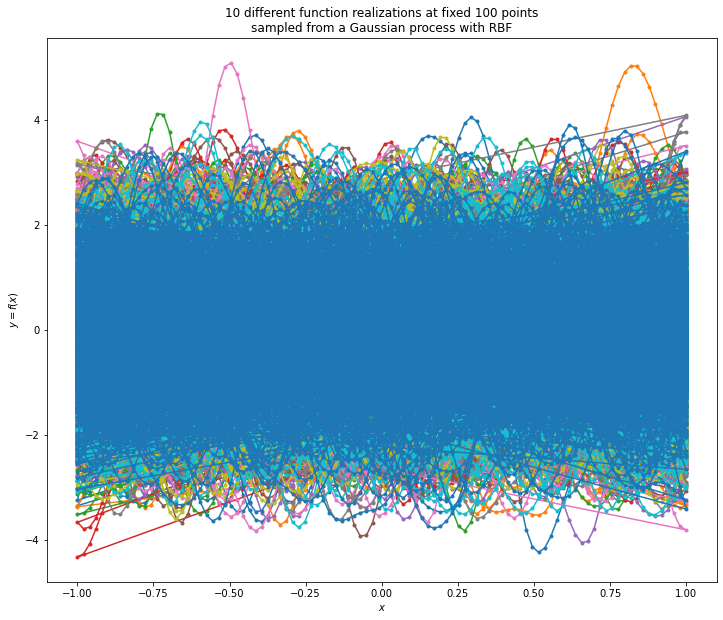

In [143]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, dt in enumerate(train_dl):
        ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), marker='o', markersize=3)
        if no > 9: break
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('10 different function realizations at fixed 100 points\n'
    'sampled from a Gaussian process with RBF')

___

In [144]:
import torch.optim as optim 

In [145]:
model = VAE(input_dim, hidden_dim1, hidden_dim2, z_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

## Training

In [146]:
from tqdm import tqdm, trange

In [147]:
t = trange(100)
for e in t:
    model.train()
    total_loss = 0
    for i, x in enumerate(train_dl):
        x = x[1].float().to(device)
        optimizer.zero_grad()
        x_pred, z_mu, z_sd = model(x)
        loss = compute_loss(x, x_pred, z_mu, z_sd)
        loss.backward()

        total_loss += loss.item()

        optimizer.step()
    t.set_description(f'Loss is {total_loss/(samples*input_dim):.3}')

Loss is 0.361: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


## Eval

In [148]:
model.eval()
z = torch.randn(5, z_dim).to(device)

with torch.no_grad():
    x_sample = model.decoder(z)

Text(0.5, 1.0, '5 different function realizations at fixed 100 points\nsampled from a VAE learned with prior as GP (RBF)')

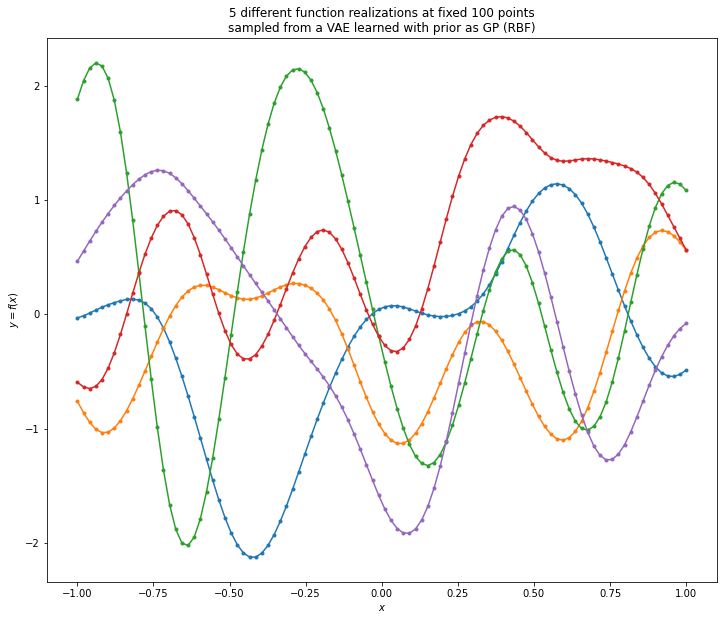

In [149]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, y in enumerate(x_sample):
    ax.plot(train_ds.evalPoints[:,0], y.cpu().numpy(), marker='o', markersize=3)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('5 different function realizations at fixed 100 points\n'
    'sampled from a VAE learned with prior as GP (RBF)')
    #plt.savefig('plots/sample_prior_vae_1d_fixed.pdf')

## Inference

In [150]:
observed = GP1D(input_dim, 1, ls=0.1)

In [151]:
observed[0][1]

array([ 1.13597143,  0.85712347,  0.66362773,  0.57750194,  0.59688305,
        0.69760687,  0.84147168,  0.987083  ,  1.09892973,  1.15219903,
        1.13330352,  1.03779185,  0.86778718,  0.63067496,  0.33980329,
        0.01657311, -0.30826407, -0.59703339, -0.81287109, -0.93078216,
       -0.94639278, -0.87635587, -0.74873885, -0.58846157, -0.40684066,
       -0.20186878,  0.03162704,  0.28973305,  0.55398646,  0.79635887,
        0.99118678,  1.12671988,  1.21032087,  1.26563692,  1.32374821,
        1.41172104,  1.54190754,  1.70513161,  1.87072607,  1.99515893,
        2.03793126,  1.97939048,  1.83244519,  1.64121355,  1.46490499,
        1.3526121 ,  1.3202458 ,  1.34104672,  1.35519457,  1.29489142,
        1.11383998,  0.80817068,  0.42013803,  0.02364444, -0.30192409,
       -0.49887255, -0.54896976, -0.47578522, -0.33221219, -0.17977353,
       -0.06877985, -0.02640602, -0.05493909, -0.13783535, -0.24905508,
       -0.36163076, -0.4533288 , -0.50918466, -0.5218409 , -0.49

In [152]:
model = model.to('cpu')

In [153]:
decoder_dict = model.decoder.state_dict()

In [154]:
decoder_dict

OrderedDict([('linear1.weight',
              tensor([[-0.0038, -0.0003, -0.0036,  ...,  0.0056, -0.0006,  0.0010],
                      [-0.0797,  0.0056,  0.0087,  ...,  0.0021,  0.0035,  0.0245],
                      [ 0.0013,  0.0011, -0.0137,  ...,  0.0045,  0.0034,  0.0094],
                      ...,
                      [ 0.0582,  0.0168, -0.0023,  ...,  0.0073,  0.0105,  0.0888],
                      [ 0.0203, -0.1222, -0.0015,  ..., -0.0174, -0.0013,  0.0771],
                      [ 0.0838,  0.1407,  0.0073,  ...,  0.0009, -0.0030, -0.0268]])),
             ('linear1.bias',
              tensor([ 1.2041e-03, -6.8327e-04,  9.8638e-04,  5.2866e-03, -3.7773e-03,
                       2.3254e-03, -1.7351e-02, -3.6779e-04, -1.7447e-03, -7.6205e-04,
                       7.9063e-04, -3.4597e-03, -6.9682e-03,  1.2014e-02,  8.7541e-03,
                       6.4158e-03,  2.6871e-03,  1.3944e-04, -1.2429e-03,  6.9809e-04,
                       1.1732e-03, -2.3247e-04, -9.7155e

In [155]:
f = observed[0][1]

In [156]:
decoder_dict['linear1.bias'].T

tensor([ 1.2041e-03, -6.8327e-04,  9.8638e-04,  5.2866e-03, -3.7773e-03,
         2.3254e-03, -1.7351e-02, -3.6779e-04, -1.7447e-03, -7.6205e-04,
         7.9063e-04, -3.4597e-03, -6.9682e-03,  1.2014e-02,  8.7541e-03,
         6.4158e-03,  2.6871e-03,  1.3944e-04, -1.2429e-03,  6.9809e-04,
         1.1732e-03, -2.3247e-04, -9.7155e-03,  2.5565e-03, -1.0149e-03,
        -1.2478e-02, -2.4452e-04,  3.4046e-03,  2.7109e-04,  7.5316e-03,
        -1.3363e-03,  4.0154e-03,  1.9352e-03,  7.2814e-03,  1.0777e-02,
         2.5113e-03, -1.8457e-03, -6.4939e-03,  4.6349e-03,  5.2307e-03,
         1.4450e-02,  1.5891e-03, -2.9024e-03,  8.2936e-04,  7.5071e-04,
         2.7101e-03,  1.5989e-03, -9.8810e-04,  9.0652e-03, -3.7888e-04,
        -1.7857e-03, -4.5879e-03, -4.4213e-03, -2.4396e-03,  6.0782e-05,
         7.0910e-04,  1.9177e-03,  3.2580e-03,  1.9683e-03, -1.8268e-02,
         1.9738e-02,  8.1141e-03,  1.7932e-02, -4.4660e-03])

In [157]:
y = f + np.random.randn(input_dim) * 0.1

In [158]:
stan_data = {
    "p": z_dim,
    "p1": hidden_dim1,
    "p2": hidden_dim2,
    'n': input_dim,
    "W1": decoder_dict['linear1.weight'].T.numpy(),
    'B1': decoder_dict['linear1.bias'].T.numpy(),
    'W2': decoder_dict['linear2.weight'].T.numpy(),
    "B2": decoder_dict['linear2.bias'].T.numpy(),
    "W3": decoder_dict['out.weight'].T.numpy(),
    "B3": decoder_dict['out.bias'].T.numpy(),
    'y': y
}

## Stan

In [159]:
import cmdstanpy

In [160]:
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.30.1
Install directory: /home/dulunche/.cmdstan
CmdStan version 2.30.1 already installed


True

In [161]:
sm = cmdstanpy.CmdStanModel(stan_file='stan_1D.stan')

In [162]:
fit = sm.sample(data= stan_data, iter_sampling=2000, iter_warmup=500, chains=4)

15:17:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:17:01 - cmdstanpy - INFO - CmdStan done processing.
15:17:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/dulunche/GP_VAE/drclab/VAE/stan_1D.stan', line 34, column 2 to column 23)
Consider re-running with show_console=True if the above output is unclear!


In [163]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,38.211400,0.059766,3.339210,32.188000,38.560400,43.097700,3121.65,1700.25,1.000490
z[1],0.218405,0.001130,0.126378,0.013489,0.217579,0.426803,12513.30,6815.50,0.999991
z[2],0.034048,0.001691,0.175245,-0.252234,0.033806,0.322473,10734.70,5846.78,1.000000
z[3],-0.041376,0.008527,1.016500,-1.735800,-0.045013,1.638830,14211.30,7740.35,0.999952
z[4],0.840035,0.001408,0.148702,0.597618,0.840747,1.088540,11158.80,6077.76,0.999948
...,...,...,...,...,...,...,...,...,...
y2[96],1.927500,0.004082,0.372225,1.308840,1.929890,2.530430,8315.20,4528.98,0.999569
y2[97],1.759210,0.004137,0.378580,1.136380,1.762750,2.381780,8374.42,4561.23,0.999906
y2[98],1.572940,0.004138,0.377324,0.954075,1.574600,2.189100,8316.18,4529.51,0.999881
y2[99],1.383360,0.003985,0.367691,0.779767,1.383090,1.976010,8513.10,4636.77,0.999910


In [164]:
out = fit.stan_variables()

In [165]:
fit.diagnose()

'Processing csv files: /tmp/tmpetj1atqw/stan_1D8_ymnfw_/stan_1D-20221105151700_1.csv, /tmp/tmpetj1atqw/stan_1D8_ymnfw_/stan_1D-20221105151700_2.csv, /tmp/tmpetj1atqw/stan_1D8_ymnfw_/stan_1D-20221105151700_3.csv, /tmp/tmpetj1atqw/stan_1D8_ymnfw_/stan_1D-20221105151700_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [166]:
out

{'z': array([[ 0.179738 ,  0.0233156, -2.12562  , ..., -0.202686 ,  1.26069  ,
         -3.28223  ],
        [ 0.288958 ,  0.0197481,  1.58918  , ...,  0.741904 , -1.18642  ,
         -2.92678  ],
        [ 0.0954268,  0.0330955, -0.751364 , ..., -0.414251 ,  0.983053 ,
         -3.09179  ],
        ...,
        [ 0.276198 , -0.120569 ,  0.915413 , ...,  1.74007  ,  0.0058614,
         -3.30845  ],
        [ 0.192    ,  0.168294 , -0.0502747, ..., -0.53222  , -0.89771  ,
         -2.81377  ],
        [ 0.215221 ,  0.389115 ,  0.351883 , ..., -0.810956 , -1.48207  ,
         -2.93242  ]]),
 'sigma2': array([0.310281, 0.378963, 0.34012 , ..., 0.362376, 0.317489, 0.314337]),
 'f': array([[0.779453, 0.86987 , 0.953167, ..., 1.66621 , 1.47757 , 1.28983 ],
        [0.635062, 0.714109, 0.789357, ..., 1.45034 , 1.27385 , 1.10338 ],
        [0.83279 , 0.933985, 1.02763 , ..., 1.58489 , 1.40838 , 1.23156 ],
        ...,
        [0.566052, 0.635807, 0.702817, ..., 1.58472 , 1.40029 , 1.21834 ],
 

In [167]:
fit.save

AttributeError: Unknown variable name: save
Available variables are z, sigma2, f, y2

## Posterior Plotting

In [168]:
import arviz as az

array([[<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>]], dtype=object)

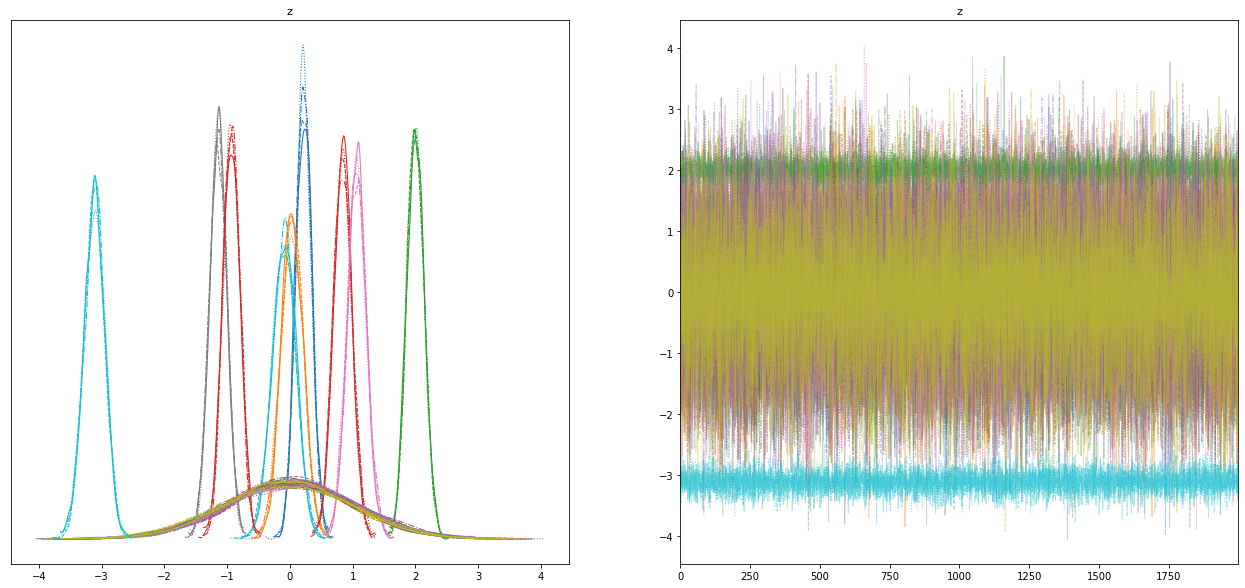

In [169]:
az.plot_trace(fit, var_names=["z"], figsize=(22,10))

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

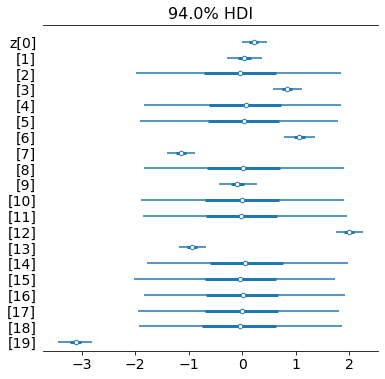

In [170]:
az.plot_forest(fit, var_names="z", combined=True)

In [171]:
import pandas as pd

In [172]:
datapoints = observed[0][0]
df = pd.DataFrame(out['y2'])

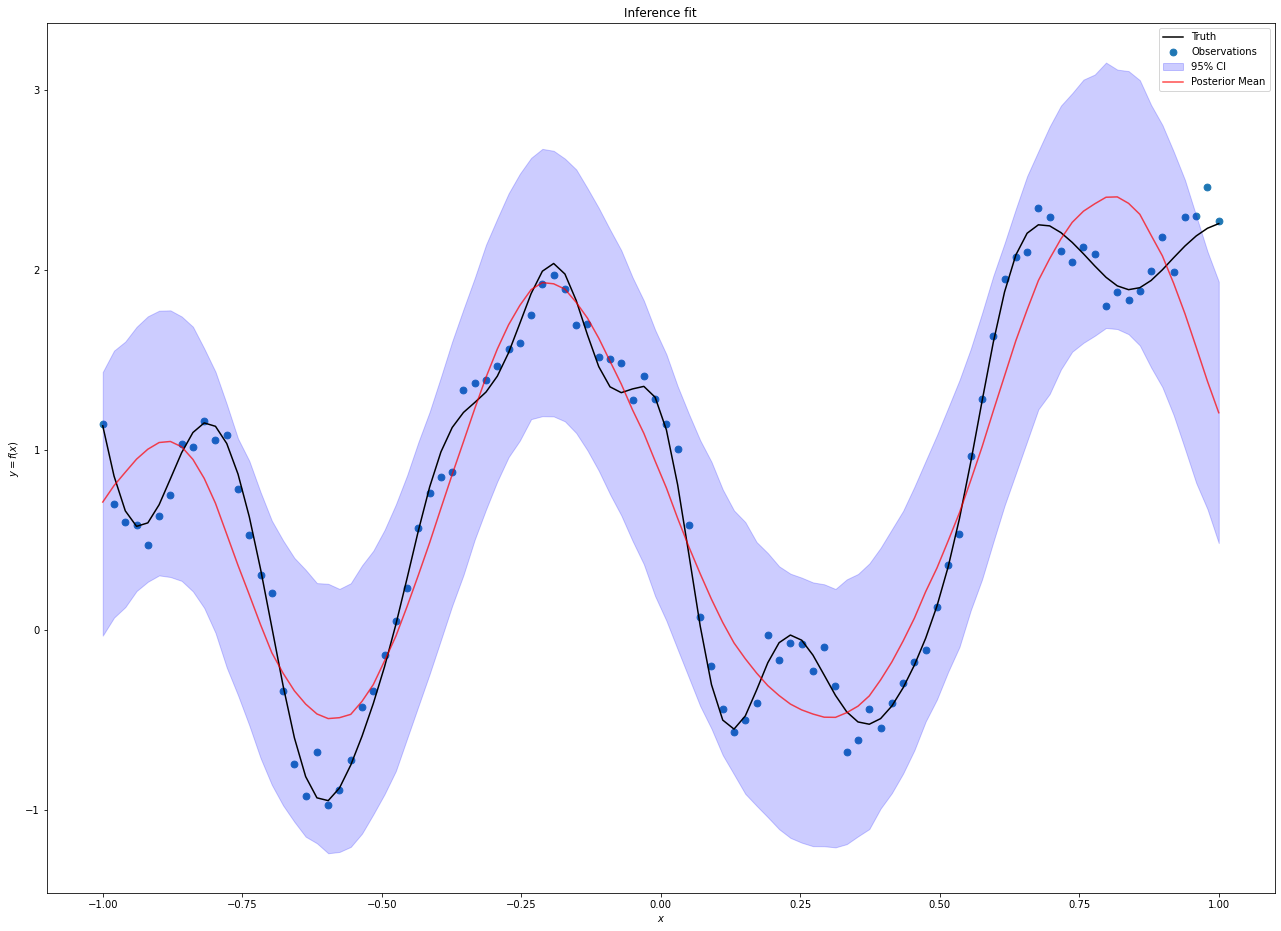

In [173]:
fig = plt.figure(figsize=(22,16))
ax = fig.add_subplot(111)
ax.plot(datapoints, f.reshape(-1,1), color="black", label="Truth")
ax.scatter(datapoints, y.reshape(-1,1), s=46, label="Observations")
ax.fill_between(datapoints, 
                df.quantile(0.025).to_numpy(), 
                df.quantile(0.975).to_numpy(),
                #facecolor = "blue",
                color="blue",
                alpha= 0.2,
                label = "95% CI"
)
ax.plot(datapoints, df.mean().to_numpy().reshape(-1,1), color="red", alpha=0.7,
    label="Posterior Mean"
)
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Inference fit')
ax.legend()
